Creating a custom CNN for detection of cancer from histology specimens.

##first imports for torch, torchvision, numpy, pandas, and os

In [1]:
# Imports here
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
!pip uninstall -y Pillow
!pip install Pillow==5.3.0

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import PIL

Uninstalling Pillow-5.3.0:
  Successfully uninstalled Pillow-5.3.0
  Using cached https://files.pythonhosted.org/packages/62/94/5430ebaa83f91cc7a9f687ff5238e26164a779cca2ef9903232268b0a318/Pillow-5.3.0-cp36-cp36m-manylinux1_x86_64.whl


In [0]:
import torch
import torch
import torch.nn.functional as F
from torch import nn
from torch import optim
from torchvision import datasets, transforms, models
from torch.utils.data.sampler import SubsetRandomSampler

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import PIL
import matplotlib as plt

In [0]:
import os
import pandas as pd
import numpy as np
import shutil

In [4]:
#Set up for cuda usage
device = torch.device("cuda" if torch.cuda.is_available else "cpu")
print("{} is available".format(device))

cuda is available


In [5]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
!ls "/content/drive/My Drive/histo_data"

models	train  valid


Below I seprate the training set into sperate train and validation folders -- I left it up to the user to place directories and creat the 0 and 1 subfolders because of different 

In [0]:
# Reorganizing data to subfolders zero and one for pytorch labels implementation as well as seperate into valid folders sperately 
# to seperate image augmentation transforms and validation transforms

labels = pd.read_csv(r'''C:\Users\gtm12\OneDrive\Documents\Jupyter Notebooks\Kaggle\Histo_cancer\train_labels.csv''')

training_path = r'''C:\Users\gtm12\OneDrive\Documents\Jupyter Notebooks\Kaggle\Histo_cancer\histo_data\train\\'''
train_path_0 = r'''C:\Users\gtm12\OneDrive\Documents\Jupyter Notebooks\Kaggle\Histo_cancer\histo_data\train\0\\'''
train_path_1 = r'''C:\Users\gtm12\OneDrive\Documents\Jupyter Notebooks\Kaggle\Histo_cancer\histo_data\train\1\\'''
valid_path_0 = r'''C:\Users\gtm12\OneDrive\Documents\Jupyter Notebooks\Kaggle\Histo_cancer\histo_data\valid\0\\'''
valid_path_1 = r'''C:\Users\gtm12\OneDrive\Documents\Jupyter Notebooks\Kaggle\Histo_cancer\histo_data\valid\1\\'''

percent_valid = .15


def file_valid_split_copy_delete(training_path, train_path_0, train_path_1, valid_path_0, valid_path_1, percent_valid):
    counter_0 = 0
    counter_1 = 0
    counter_false = 0
    counter_true = 0
    
    for i in range(len(labels)):
        if labels.label[i] == 0:
            counter_false +=1
        if labels.label[i] == 1:
            counter_true +=1

    train_split_0 = int(percent_valid * counter_false)
    train_split_1 = int(percent_valid * counter_true)

    for i in range(len(labels)):
        file_name = str(labels.id[i]) + '.tif'
        if labels.label[i].item() == 0:
            if counter_0 <= train_split_0:
                file_path_copy = valid_path_0
                counter_0 += 1
                file_origin = training_path + file_name
                file_path_copy = file_path_copy + file_name
                shutil.copy2(file_origin, file_path_copy)
                os.remove(file_origin)
            else:
                file_path_copy = train_path_0
                counter_0 += 1
                file_origin = training_path + file_name
                file_path_copy = file_path_copy + file_name
                shutil.copy2(file_origin, file_path_copy)
                os.remove(file_origin)

        elif labels.label[i].item() == 1:
            if counter_1 <= trains_split_1:
                file_path_copy = valid_path_1
                counter_1 += 1
                file_origin = training_path + file_name
                file_path_copy = file_path_copy + file_name
                shutil.copy2(file_origin, file_path_copy)
                os.remove(file_origin)
            else:
                file_path_copy = train_path_1
                counter_0 += 1
                file_origin = training_path + file_name
                file_path_copy = file_path_copy + file_name
                shutil.copy2(file_origin, file_path_copy)
                os.remove(file_origin)
                
    print("files have been relocated")
    
    return

In [0]:
file_valid_split_copy_delete(training_path, train_path_0, train_path_1, valid_path_0, valid_path_1, percent_valid)

In [0]:
# Begin to load Data Transforms and split validation set

In [0]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load

# percentage of training set to use as validation
#valid_size = 0.15
#file directories
data_dir =  '/content/drive/My Drive/histo_data'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
#test_dir = data_dir + '/test'

In [0]:
# TODO: Define your transforms for the training and validation sets
train_transforms = transforms.Compose([transforms.CenterCrop(32),
                                      transforms.Resize(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                          [0.229, 0.224, 0.225])])

valid_transforms = transforms.Compose([transforms.CenterCrop(32),
                                      transforms.Resize(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                          [0.229, 0.224, 0.225])])

#test_transforms = transforms.Compose([transforms.CenterCrop(32),
#                                      transforms.ToTensor(),
#                                      transforms.Normalize([0.485, 0.456, 0.406],
#                                                          [0.229, 0.224, 0.225])])



# TODO: Load the datasets with ImageFolder
train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
valid_data = datasets.ImageFolder(valid_dir, transform=valid_transforms)
#test_data = datasets.ImageFolder(test_dir, transform=test_transforms)


# TODO: Using the image datasets and the trainforms, define the dataloaders
#trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
#validloader = torch.utils.data.DataLoader(valid_data, batch_size=64, shuffle=True)
# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=64, shuffle=True)
#test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
#    num_workers=num_workers)



Visualize data

In [0]:
# helper function to un-normalize and display an image
import matplotlib.pyplot as plt
%matplotlib inline
def imshow(img):
    img = .224*img + .456  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

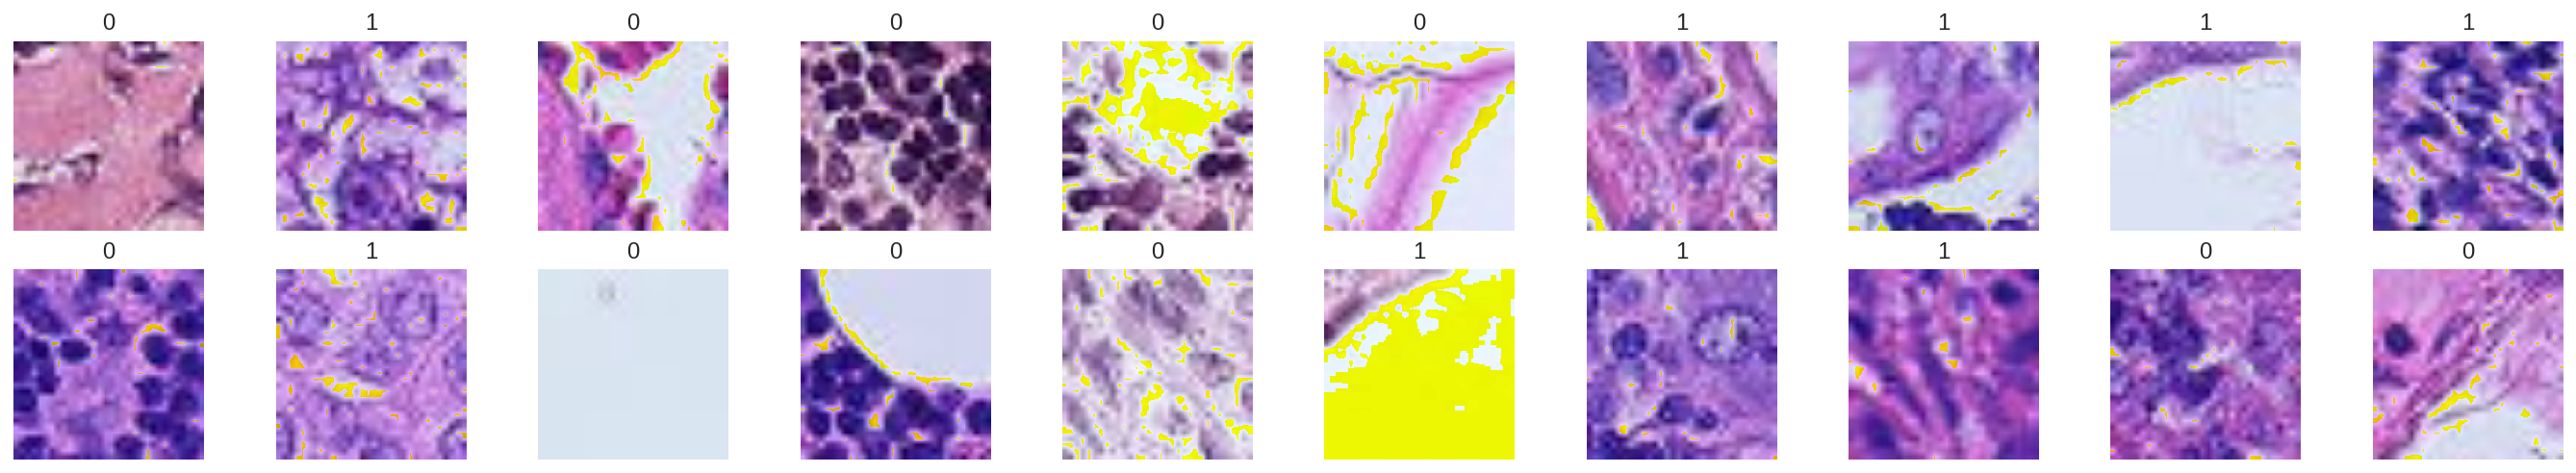

In [10]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(24, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(labels[idx].item())

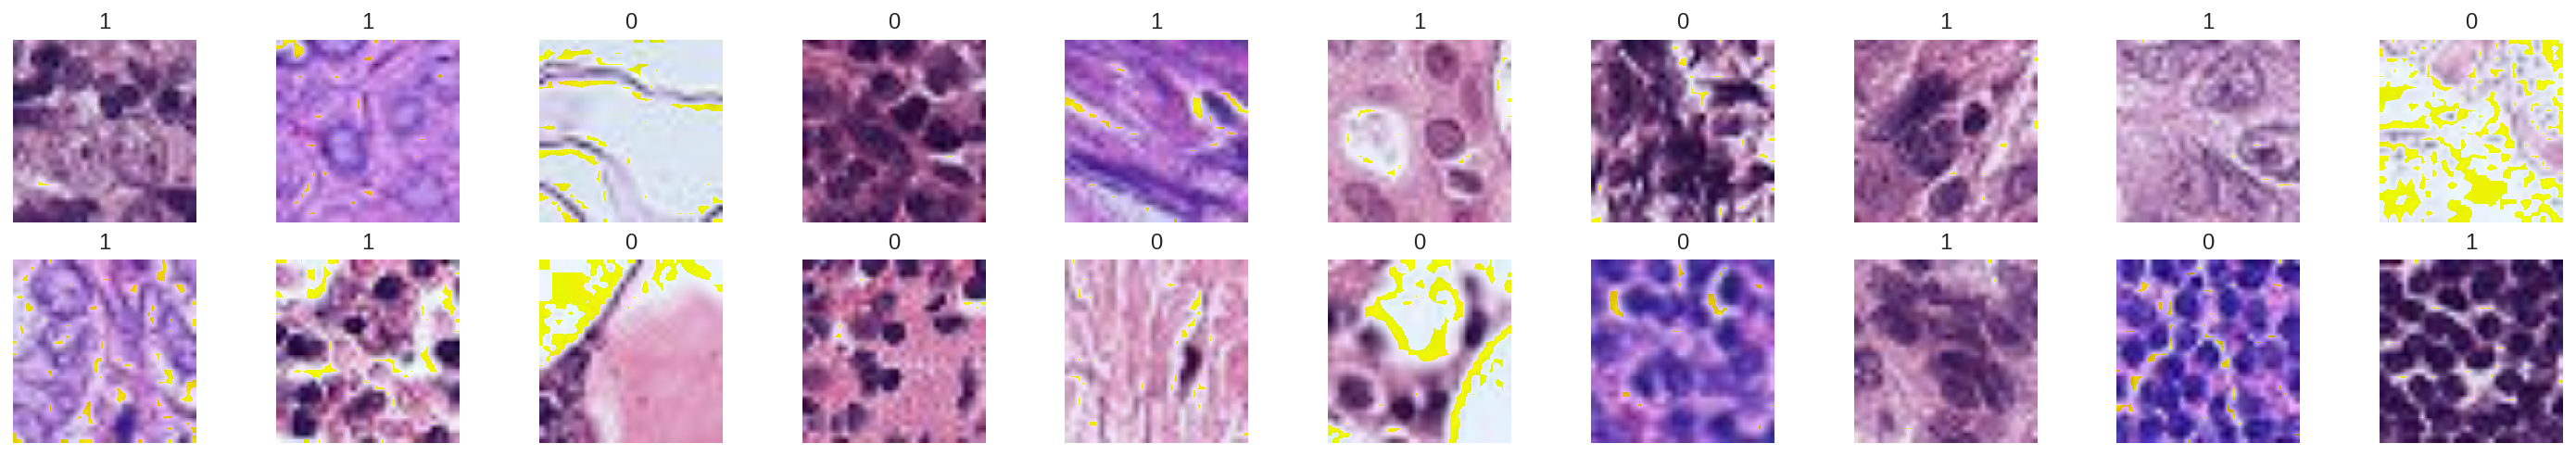

In [12]:
# obtain one batch of training images
dataiter = iter(valid_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(labels[idx].item())

##Time to define our CNN model

In [13]:
model = models.resnet18(pretrained=True)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [15]:
for param in model.parameters():
  param.requires_grad = False
  
from collections import OrderedDict
fc = nn.Sequential(OrderedDict([
    ('hidden_1', nn.Linear(512, 512)),
    ('relu1', nn.ReLU()),
    ('dropout1', nn.Dropout(0.2)),
    ('hidden_2', nn.Linear(512, 512)),
    ('relu2', nn.ReLU()),
    ('dropout_2', nn.Dropout(0.2)),
    ('hidden_3', nn.Linear(512, 128)),
    ('relu3', nn.ReLU()),
    ('dropout_3', nn.Dropout(0.2)),
    ('hidden_4', nn.Linear(128, 2)),
    ('output', nn.LogSoftmax(dim=1))
]))

model.fc = fc
for param in model.fc.parameters():
    param.requires_grad = True

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

##Add Optimizer and Loss finctions

In [0]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=.005)

#Training Loop

In [19]:
steps = 0
running_loss = 0
epochs = 150
print_every = 51
valid_loss_min = np.Inf

for e in range(epochs):
  model.train()
  model.to(device)
  counter = 0
  for images, labels in train_loader:
    steps += 1
    #print(steps)
    images, labels = images.to(device), labels.to(device)
    
    optimizer.zero_grad()
    
    output = model.forward(images)
    loss = criterion(output, labels)
    loss.backward()
    optimizer.step()
    
    running_loss += loss.item()
    #print(counter)
    #counter += 1
    if steps % print_every == 0:
      model.eval()
      
      
      accuracy = 0
      test_loss = 0
      with torch.no_grad():
        for images, labels in valid_loader:
          images, labels = images.to(device), labels.to(device)
        
          output = model(images)
          test_loss += criterion(output, labels).item()
        
          ps = torch.exp(output)
          equality = (labels.data == ps.max(1)[1])
          accuracy += equality.type_as(torch.FloatTensor()).mean()
        
      print("Epoch: {}/{}.. ".format(e+1, epochs),
            "Training Loss: {:.3f}.. ".format(running_loss/print_every),
            "Validation Loss: {:.3f}.. ".format(test_loss/len(valid_loader)),
            "Validation Accuracy: {:.3f}".format(accuracy/len(valid_loader)))
      
      # save model if validation loss has decreased
      valid_loss = test_loss/len(valid_loader)
      
      if valid_loss <= valid_loss_min:
        
        checkpoint = {'batch_size': 64,
                      'valid_transforms': valid_transforms,
                      'train_transforms': train_transforms,
                      'model': model,
                      'classifier': fc,
                      'criterion': criterion,
                      'optimizer': optimizer.state_dict(),
                      'state_dict': model.state_dict()
                      }
        
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.
              format(valid_loss_min, valid_loss))
        
        torch.save(checkpoint,'/content/drive/My Drive/histo_data/models/model_checkpoint.pth')
        valid_loss_min = valid_loss
      
      running_loss = 0
      model.train()
        
        

Epoch: 1/150..  Training Loss: 0.528..  Validation Loss: 0.493..  Validation Accuracy: 0.768
Validation loss decreased (inf --> 0.492624).  Saving model ...
Epoch: 1/150..  Training Loss: 0.553..  Validation Loss: 0.475..  Validation Accuracy: 0.782
Validation loss decreased (0.492624 --> 0.474524).  Saving model ...
Epoch: 1/150..  Training Loss: 0.520..  Validation Loss: 0.575..  Validation Accuracy: 0.735
Epoch: 1/150..  Training Loss: 0.523..  Validation Loss: 0.519..  Validation Accuracy: 0.768
Epoch: 1/150..  Training Loss: 0.521..  Validation Loss: 0.483..  Validation Accuracy: 0.786
Epoch: 1/150..  Training Loss: 0.508..  Validation Loss: 0.468..  Validation Accuracy: 0.782
Validation loss decreased (0.474524 --> 0.468215).  Saving model ...
Epoch: 2/150..  Training Loss: 0.505..  Validation Loss: 0.462..  Validation Accuracy: 0.788
Validation loss decreased (0.468215 --> 0.461683).  Saving model ...
Epoch: 2/150..  Training Loss: 0.499..  Validation Loss: 0.471..  Validation A

KeyboardInterrupt: ignored